# Tests for the synthetic data module

In [ ]:
#| hide 
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from fastcore.test import *
from circadian.lights import LightSchedule
from circadian.synthetic_data import generate_activity_from_light

## Activity from Light

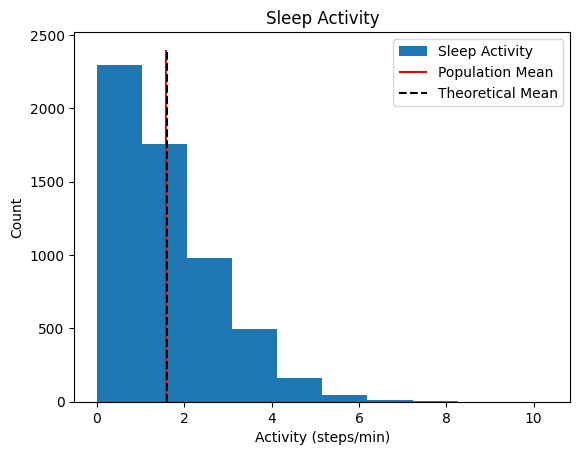

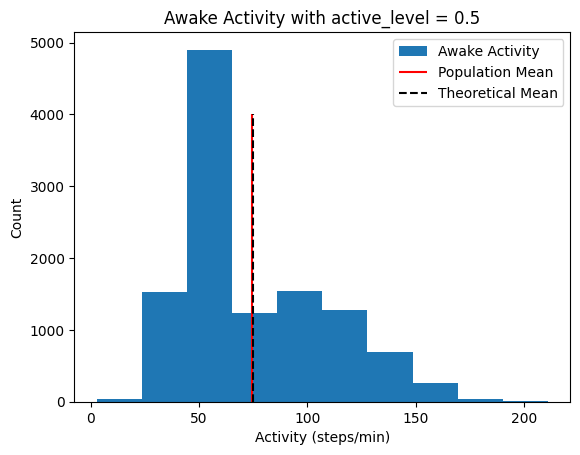

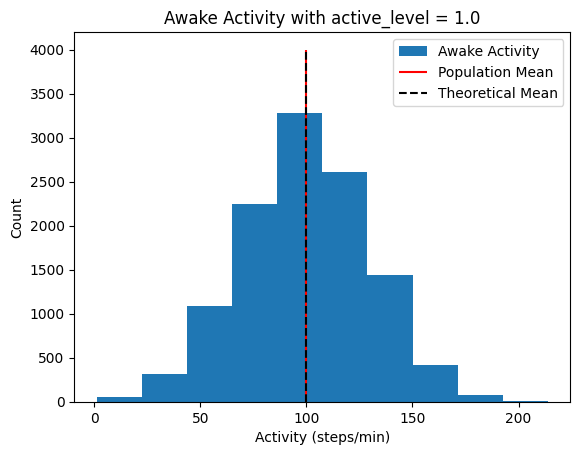

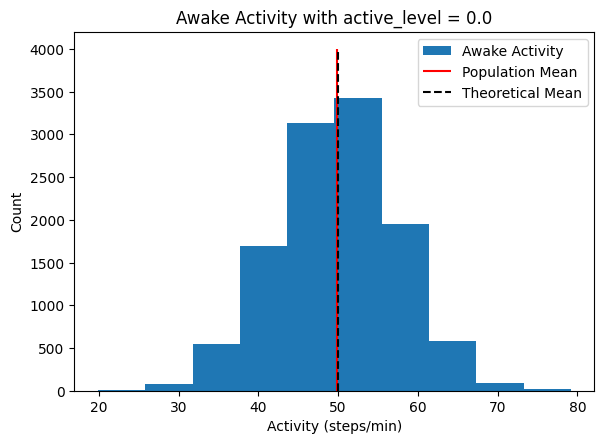

In [ ]:
# test generate_activity_from_light

# Activity levels.
mu_l = 50    # Mean of low activity levels.
mu_h = 100   # Mean of high activity levels.
mu_s = 0    # Mean of sleep activity levels.

# Activity uncertainty.
sigma_l = 7.5   # Std of low activity levels.
sigma_h = 30    # Std of high activity levels.
sigma_s = 2     # Std of activity during sleep.

# The person's activity level from 0 to 1.
active_level = 0.5

# Number of days and samples of interest.
num_days = 12

# Time vector.
time = np.arange(0, 24*num_days, 1/60)

# Light schedules.
regular_light = LightSchedule.Regular()

# Generate activity signal.
activity = generate_activity_from_light(time, regular_light, mu_l, mu_h, mu_s, sigma_l, sigma_h, sigma_s, active_level)

# Test that mean sleep activity is close to theoretical mean of a half-normal distribution when the pulse is zero
# Half-normal distribution: https://en.wikipedia.org/wiki/Half-normal_distribution
test_eq(
    np.isclose(np.mean(activity[np.where(regular_light(time) == 0.0)]),
        sigma_s*np.sqrt(2/np.pi), # mean of a half-normal distribution
        atol=1e-1,
        rtol=1e-3),
    True
)
# Plot a histogram of sleep activity levels, distribution, theoretical mean and sample mean
plt.figure()
plt.hist(activity[np.where(regular_light(time) == 0.0)], label="Sleep Activity")
plt.vlines(np.mean(activity[np.where(regular_light(time) == 0.0)]), ymin=0, ymax=2400, colors='r', linestyles='solid', label="Population Mean")
plt.vlines(sigma_s*np.sqrt(2/np.pi), ymin=0, ymax=2400, colors='k', linestyles='dashed', label="Theoretical Mean")
plt.legend()
plt.xlabel("Activity (steps/min)")
plt.ylabel("Count")
plt.title("Sleep Activity")

# Test: activity is close to theoretical mean with the high and low distributions
test_eq(
    np.isclose(np.mean(activity[np.where(regular_light(time) > 0.0)]),
        (active_level*mu_h) + ((1-active_level)*mu_l), # theoretical mean of activity level
        atol=7.5e-1,
        rtol=1e-3),
    True
)
# Plot a histogram of awake activity levels, distribution, theoretical mean and sample mean
plt.figure()
plt.hist(activity[np.where(regular_light(time) > 0.0)], label="Awake Activity")
plt.vlines(np.mean(activity[np.where(regular_light(time) > 0.0)]), ymin=0, ymax=4000, colors='r', linestyles='solid', label="Population Mean")
plt.vlines((active_level*mu_h) + ((1-active_level)*mu_l), ymin=0, ymax=4000, colors='k', linestyles='dashed', label="Theoretical Mean")
plt.legend()
plt.xlabel("Activity (steps/min)")
plt.ylabel("Count")
plt.title(f"Awake Activity with active_level = {active_level}")

# Test: When active level is 1.0, awake activity should be drawn only from the high distribution
active_level = 1.0
activity = generate_activity_from_light(
    time, regular_light, mu_l, mu_h, mu_s,
    sigma_l, sigma_h, sigma_s, active_level
)
test_eq(
    np.isclose(np.mean(activity[np.where(regular_light(time) > 0.0)]),
        mu_h,
        atol=7.5e-1,
        rtol=1e-3),
    True
)
# Plot a histogram of awake activity levels, distribution, theoretical mean and sample mean
plt.figure()
plt.hist(activity[np.where(regular_light(time) > 0.0)], label="Awake Activity")
plt.vlines(np.mean(activity[np.where(regular_light(time) > 0.0)]), ymin=0, ymax=4000, colors='r', linestyles='solid', label="Population Mean")
plt.vlines(mu_h, ymin=0, ymax=4000, colors='k', linestyles='dashed', label="Theoretical Mean")
plt.legend()
plt.xlabel("Activity (steps/min)")
plt.ylabel("Count")
plt.title(f"Awake Activity with active_level = {active_level}")

# Test: When active level is 0.0, activity should have the low level mean
active_level = 0.0
activity = generate_activity_from_light(
    time, regular_light, mu_l, mu_h, mu_s,
    sigma_l, sigma_h, sigma_s, active_level
)
test_eq(
    np.isclose(np.mean(activity[np.where(regular_light(time) > 0.0)]),
        mu_l,
        atol=7.5e-1,
        rtol=1e-3),
    True
)
# Plot a histogram of awake activity levels, distribution, theoretical mean and sample mean
plt.figure()
plt.hist(activity[np.where(regular_light(time) > 0.0)], label="Awake Activity")
plt.vlines(np.mean(activity[np.where(regular_light(time) > 0.0)]), ymin=0, ymax=4000, colors='r', linestyles='solid', label="Population Mean")
plt.vlines(mu_l, ymin=0, ymax=4000, colors='k', linestyles='dashed', label="Theoretical Mean")
plt.legend()
plt.xlabel("Activity (steps/min)")
plt.ylabel("Count")
plt.title(f"Awake Activity with active_level = {active_level}")

plt.tight_layout(pad=2,w_pad=2,h_pad=2)

# Tests: Error handling
test_fail(lambda: generate_activity_from_light(time=1, light=regular_light), contains="`time` must be a Numpy array")
test_fail(lambda: generate_activity_from_light(time=time, light=1), contains="`light` must be a `LightSchedule` object")
test_fail(lambda: generate_activity_from_light(time, regular_light, mu_l='a'), contains="mu_l must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, mu_l=-1.0), contains="mu_l must be a nonnegative float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, mu_h='a'), contains="mu_h must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, mu_h=-1.0), contains="mu_h must be a nonnegative float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, mu_s='a'), contains="mu_s must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, mu_s=-1.0), contains="mu_s must be a nonnegative float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, sigma_l='a'), contains="sigma_l must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, sigma_l=-1.0), contains="sigma_l must be a nonnegative float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, sigma_h='a'), contains="sigma_h must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, sigma_h=-1.0), contains="sigma_h must be a nonnegative float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, sigma_s='a'), contains="sigma_s must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, sigma_s=-1.0), contains="sigma_s must be a nonnegative float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, active_level='a'), contains="active_level must be a float or int")
test_fail(lambda: generate_activity_from_light(time, regular_light, active_level=-1.0), contains="active_level must be between 0.0 and 1.0")
test_fail(lambda: generate_activity_from_light(time, regular_light, active_level=2.0), contains="active_level must be between 0.0 and 1.0")